# 🌾 YieldWise Core v1 — Government Data Model

## Statistical Crop Yield Forecaster (Data.gov.in)

This notebook builds a **realistic, production-grade crop yield prediction model** using **only** government of India crop production data (processed/base_crop_yield.csv).

### Key Principles:
- **Data-Driven**: No agronomic assumptions, no synthetic features
- **Government-Only**: Real historical crop data from India's agricultural ministry
- **Time-Aware**: Train/test split respects temporal order
- **Transparent**: Each phase clearly documented and validated

### Phases:
1. Load & Explore Data
2. Cleaning & Validation
3. Feature Selection
4. Preprocessing Pipeline
5. Model Training & Benchmarking
6. Final Model & Export
7. Reality & Sanity Checks
8. Summary Report
9. Custom Input Testing

---

PHASE 1 — LOAD & EXPLORE DATA

📦 Loading from: c:\Users\athar\Downloads\YieldPrediction\datasets\gov_crop_data.csv
⚠️ Initial load failed: Error tokenizing data. C error: Expected 7 fields in line 2001, saw 13

   Retrying with error handling...
   ✓ Successfully loaded with 245191 rows

📐 Dataset Shape: (245191, 7)

📋 Columns (7):
    1. State_Name
    2. District_Name
    3. Crop_Year
    4. Season
    5. Crop
    6. Area
    7. Production

🔢 Data Types:
State_Name        object
District_Name     object
Crop_Year          int64
Season            object
Crop              object
Area             float64
Production       float64
dtype: object

👀 First 10 rows:


,State_Name,District_Name,Crop_Year,Season,Crop,Area,Production
0,Andaman and Nicobar Islands,NICOBARS,2000,Kharif,Arecanut,1254.0,2000.0
1,Andaman and Nicobar Islands,NICOBARS,2000,Kharif,Other Kharif pulses,2.0,1.0
2,Andaman and Nicobar Islands,NICOBARS,2000,Kharif,Rice,102.0,321.0
3,Andaman and Nicobar Islands,NICOBARS,2000,Whole Year,Banana,176.0,641.0
4,Andaman and Nicobar Islands,NICOBARS,2000,Whole Year,Cashewnut,720.0,165.0
5,Andaman and Nicobar Islands,NICOBARS,2000,Whole Year,Coconut,18168.0,65100000.0
6,Andaman and Nicobar Islands,NICOBARS,2000,Whole Year,Dry ginger,36.0,100.0
7,Andaman and Nicobar Islands,NICOBARS,2000,Whole Year,Sugarcane,1.0,2.0
8,Andaman and Nicobar Islands,NICOBARS,2000,Whole Year,Sweet potato,5.0,15.0
9,Andaman and Nicobar Islands,NICOBARS,2000,Whole Year,Tapioca,40.0,169.0



🕳️ Missing Values:
Production    3714

🔄 Standardizing column names...
   Calculating yield = production / area...
   ✓ Yield calculated

📊 Yield Distribution:
count    241477.000000
mean         41.547962
std         817.342362
min           0.000000
25%           0.513583
50%           1.000000
75%           2.354267
max       88000.000000


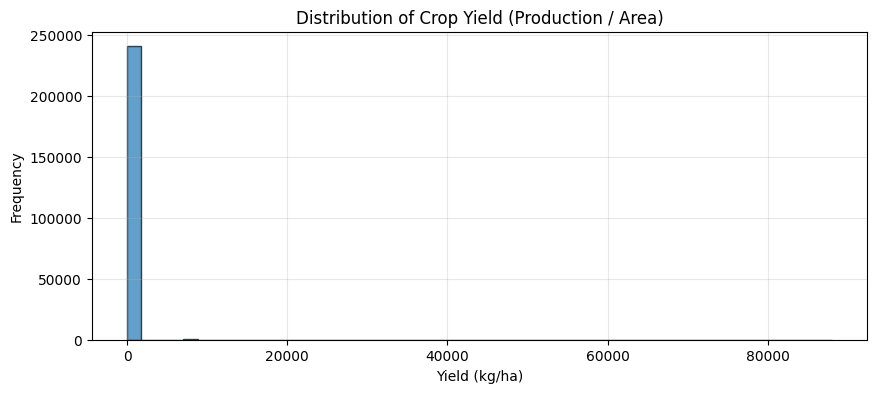


✅ Unique values:
   States: 33
   Districts: 646
   Crops: 124
   Seasons: 6
   Years: 1997-2015

✅ Phase 1 complete.


In [ ]:
# =============================================================================
# PHASE 1 — LOAD & EXPLORE DATA
# =============================================================================

import os
import json
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")

# Setup
BASE_DIR = Path(os.getcwd())
DATA_PATH = BASE_DIR / 'datasets' / 'gov_crop_data.csv'
MODELS_DIR = BASE_DIR / 'models'
MODELS_DIR.mkdir(parents=True, exist_ok=True)

print("="*80)
print("PHASE 1 — LOAD & EXPLORE DATA")
print("="*80)

# Verify data source
if not DATA_PATH.exists():
    raise FileNotFoundError(f"Dataset not found at: {DATA_PATH}")

print(f"\n📦 Loading from: {DATA_PATH}")

# Load dataset with robust error handling
try:
    raw_df = pd.read_csv(DATA_PATH)
except Exception as e:
    print(f"⚠️ Initial load failed: {e}")
    print("   Retrying with error handling...")
    raw_df = pd.read_csv(DATA_PATH, on_bad_lines='skip', engine='python')
    print(f"   ✓ Successfully loaded with {len(raw_df)} rows")

# Basic info
print(f"\n📐 Dataset Shape: {raw_df.shape}")
print(f"\n📋 Columns ({len(raw_df.columns)}):")
for i, col in enumerate(raw_df.columns, 1):
    print(f"   {i:2d}. {col}")

print(f"\n🔢 Data Types:")
print(raw_df.dtypes)

print(f"\n👀 First 10 rows:")
display(raw_df.head(10))

# Missing values
print(f"\n🕳️ Missing Values:")
missing = raw_df.isna().sum().sort_values(ascending=False)
if missing.sum() > 0:
    print(missing[missing > 0].to_string())
else:
    print("   None detected ✓")

# Standardize column names and calculate yield
print(f"\n🔄 Standardizing column names...")
raw_df = raw_df.rename(columns={
    'State_Name': 'state',
    'District_Name': 'district',
    'Crop_Year': 'year',
    'Season': 'season',
    'Crop': 'crop',
    'Area': 'area',
    'Production': 'production'
})

# Calculate yield from production and area
print(f"   Calculating yield = production / area...")
raw_df['yield'] = (raw_df['production'] / raw_df['area']) * 1000  # Convert tonnes/ha to kg/ha
print(f"   ✓ Yield calculated (converted from tonnes/ha to kg/ha)")

# Yield distribution
print(f"\n📊 Yield Distribution:")
yield_stats = raw_df['yield'].describe()
print(yield_stats.to_string())

# Histogram
plt.figure(figsize=(10, 4))
plt.hist(raw_df['yield'], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Yield (kg/ha)')
plt.ylabel('Frequency')
plt.title('Distribution of Crop Yield (Production / Area)')
plt.grid(True, alpha=0.3)
plt.show()

# Data source verification
print(f"\n✅ Unique values:")
print(f"   States: {raw_df['state'].nunique()}")
print(f"   Districts: {raw_df['district'].nunique()}")
print(f"   Crops: {raw_df['crop'].nunique()}")
print(f"   Seasons: {raw_df['season'].nunique()}")
print(f"   Years: {raw_df['year'].min():.0f}-{raw_df['year'].max():.0f}")

print("\n✅ Phase 1 complete.")

## PHASE 2 — CLEANING & VALIDATION

Standardize categorical features, convert numeric types, remove invalid rows, and cap outliers at 99.5 percentile.

In [2]:
# =============================================================================
# PHASE 2 — CLEANING & VALIDATION
# =============================================================================

import re

print("="*80)
print("PHASE 2 — CLEANING & VALIDATION")
print("="*80)

initial_rows = len(raw_df)
df = raw_df.copy()

# 1) Standardize text columns
text_cols = ['state', 'district', 'crop', 'season']
for col in text_cols:
    df[col] = df[col].astype(str).str.strip().str.lower()

print(f"\n✓ Text columns standardized (lowercase, stripped)")

# 2) Convert numeric columns safely
for col in ['year', 'area', 'production', 'yield']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

print(f"✓ Numeric columns converted safely")

# 3) Remove invalid rows
rows_before = len(df)

# Missing yield
df = df.dropna(subset=['yield'])
print(f"\n🗑️ Removed rows with missing yield: {rows_before - len(df):,}")

# Non-positive yield
rows_before = len(df)
df = df[df['yield'] > 0]
print(f"🗑️ Removed rows with yield ≤ 0: {rows_before - len(df):,}")

# Non-positive area
rows_before = len(df)
df = df.dropna(subset=['area'])
df = df[df['area'] > 0]
print(f"🗑️ Removed rows with area ≤ 0 or missing: {rows_before - len(df):,}")

# Non-negative production
rows_before = len(df)
df = df[df['production'] >= 0]
print(f"🗑️ Removed rows with production < 0: {rows_before - len(df):,}")

# 4) Filter realistic years (1997–2024)
rows_before = len(df)
min_year = max(1997, df['year'].min())
max_year = 2024
df = df[(df['year'] >= min_year) & (df['year'] <= max_year)]
print(f"🗑️ Filtered to years {min_year}–{max_year}: {rows_before - len(df):,} rows removed")

# 5) Cap extreme outliers (99.5 percentile)
upper_yield = df['yield'].quantile(0.995)
lower_yield = df['yield'].quantile(0.005)
df['yield'] = df['yield'].clip(lower=lower_yield, upper=upper_yield)

print(f"\n✓ Yield capped to 0.5–99.5 percentile range: [{lower_yield:.1f}, {upper_yield:.1f}]")

total_removed = initial_rows - len(df)
print(f"\n📊 Total rows removed: {total_removed:,}")
print(f"   Remaining: {len(df):,} ({100*len(df)/initial_rows:.1f}%)")

# Summary stats after cleaning
print(f"\n📊 Post-cleaning Yield Distribution:")
print(df['yield'].describe().to_string())

print("\n✅ Phase 2 complete.")

PHASE 2 — CLEANING & VALIDATION

✓ Text columns standardized (lowercase, stripped)
✓ Numeric columns converted safely

🗑️ Removed rows with missing yield: 3,714
🗑️ Removed rows with yield ≤ 0: 3,506
🗑️ Removed rows with area ≤ 0 or missing: 0
🗑️ Removed rows with production < 0: 0
🗑️ Filtered to years 1997–2024: 0 rows removed

✓ Yield capped to 0.5–99.5 percentile range: [0.1, 120.6]

📊 Total rows removed: 7,220
   Remaining: 237,971 (97.1%)

📊 Post-cleaning Yield Distribution:
count    237971.000000
mean          4.985219
std          14.218912
min           0.062903
25%           0.532278
50%           1.000000
75%           2.400000
max         120.649995

✅ Phase 2 complete.


## PHASE 3 — FEATURE SELECTION

Select features (X) and target (y) for government-only model.

In [3]:
# =============================================================================
# PHASE 3 — FEATURE SELECTION
# =============================================================================

print("="*80)
print("PHASE 3 — FEATURE SELECTION")
print("="*80)

# Define feature groups
categorical_features = ['state', 'district', 'crop', 'season']
numerical_features = ['year', 'area']
target_col = 'yield'

print(f"\n📚 Feature Specification:")
print(f"   Categorical (4): {categorical_features}")
print(f"   Numerical (2): {numerical_features}")
print(f"   Target: {target_col}")

# Prepare X and y
all_features = categorical_features + numerical_features
X = df[all_features].copy()
y = df[target_col].copy()

print(f"\n📐 Data shapes:")
print(f"   X: {X.shape}")
print(f"   y: {y.shape}")

print(f"\n💡 Why this feature set?")
print(f"   state/district/crop: Agricultural geography & crop identity")
print(f"   season: Monsoon & farming cycle patterns")
print(f"   year: Temporal trends in production technology & climate")
print(f"   area: Scale effect — larger farms may optimize differently")
print(f"   → All observable at data.gov.in, no synthetic data")

print("\n✅ Phase 3 complete.")

PHASE 3 — FEATURE SELECTION

📚 Feature Specification:
   Categorical (4): ['state', 'district', 'crop', 'season']
   Numerical (2): ['year', 'area']
   Target: yield

📐 Data shapes:
   X: (237971, 6)
   y: (237971,)

💡 Why this feature set?
   state/district/crop: Agricultural geography & crop identity
   season: Monsoon & farming cycle patterns
   year: Temporal trends in production technology & climate
   area: Scale effect — larger farms may optimize differently
   → All observable at data.gov.in, no synthetic data

✅ Phase 3 complete.


## PHASE 4 — PREPROCESSING PIPELINE

Build categorical and numerical transformers.

In [4]:
# =============================================================================
# PHASE 4 — PREPROCESSING PIPELINE
# =============================================================================

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

print("="*80)
print("PHASE 4 — PREPROCESSING PIPELINE")
print("="*80)

# Categorical transformer
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Numerical transformer
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

print(f"\n✓ Categorical transformer: OneHotEncoder (unknown='ignore')")
print(f"✓ Numerical transformer: StandardScaler + median imputation")
print(f"✓ ColumnTransformer configured")
print(f"   - Numerical ({len(numerical_features)}): {numerical_features}")
print(f"   - Categorical ({len(categorical_features)}): {categorical_features}")

print("\n✅ Phase 4 complete.")

PHASE 4 — PREPROCESSING PIPELINE

✓ Categorical transformer: OneHotEncoder (unknown='ignore')
✓ Numerical transformer: StandardScaler + median imputation
✓ ColumnTransformer configured
   - Numerical (2): ['year', 'area']
   - Categorical (4): ['state', 'district', 'crop', 'season']

✅ Phase 4 complete.


## PHASE 5 — MODEL TRAINING & BENCHMARKING

Time-aware split and model comparison.

In [6]:
# =============================================================================
# PHASE 5 — MODEL TRAINING & BENCHMARKING
# =============================================================================

import time
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Optional: XGBoost
try:
    from xgboost import XGBRegressor
    XGB_AVAILABLE = True
except Exception:
    XGB_AVAILABLE = False

print("="*80)
print("PHASE 5 — MODEL TRAINING & BENCHMARKING")
print("="*80)

# TIME-AWARE SPLIT (train before 2012, test from 2012 onwards)
train_mask = df['year'] < 2012
test_mask = df['year'] >= 2012

X_train, X_test = X[train_mask].copy(), X[test_mask].copy()
y_train, y_test = y[train_mask].copy(), y[test_mask].copy()

print(f"\n⏰ Time-aware split:")
print(f"   Train (< 2012): {len(X_train):,} samples, years {X_train['year'].min():.0f}–{X_train['year'].max():.0f}")
print(f"   Test (≥ 2012):  {len(X_test):,} samples, years {X_test['year'].min():.0f}–{X_test['year'].max():.0f}")

# Define models
models = {
    'LinearRegression': LinearRegression(),
    'RandomForestRegressor': RandomForestRegressor(
        n_estimators=100,
        max_depth=20,
        min_samples_split=100,
        n_jobs=-1,
        random_state=42,
        verbose=0
    ),
    'GradientBoostingRegressor': GradientBoostingRegressor(
        n_estimators=100,
        learning_rate=0.05,
        max_depth=3,
        subsample=0.8,
        random_state=42
    )
}

if XGB_AVAILABLE:
    models['XGBRegressor'] = XGBRegressor(
        n_estimators=500,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.2,
        reg_lambda=1.5,
        random_state=42,
        n_jobs=-1,
        verbosity=0
    )

results = []

# Train and evaluate each model
for name, regressor in models.items():
    print(f"\n🔧 Training {name}...")
    
    # Build full pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', regressor)
    ])
    
    # Train
    t0 = time.time()
    pipeline.fit(X_train, y_train)
    train_time = time.time() - t0
    
    # Predict
    y_pred = pipeline.predict(X_test)
    
    # Evaluate
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    
    results.append({
        'model': name,
        'r2': r2,
        'rmse': rmse,
        'mae': mae,
        'train_time_s': train_time
    })
    
    print(f"   R² = {r2:.4f}, RMSE = {rmse:.2f}, MAE = {mae:.2f}, Time = {train_time:.2f}s")

# Results table
results_df = pd.DataFrame(results).sort_values('rmse')
print(f"\n📊 MODEL COMPARISON TABLE:")
print(results_df.to_string(index=False))

print("\n✅ Phase 5 complete.")

PHASE 5 — MODEL TRAINING & BENCHMARKING

⏰ Time-aware split:
   Train (< 2012): 200,042 samples, years 1997–2011
   Test (≥ 2012):  37,929 samples, years 2012–2015

🔧 Training LinearRegression...
   R² = 0.6574, RMSE = 8.36, MAE = 3.14, Time = 46.90s

🔧 Training RandomForestRegressor...
   R² = 0.8367, RMSE = 5.77, MAE = 1.79, Time = 1181.97s

🔧 Training GradientBoostingRegressor...
   R² = 0.7597, RMSE = 7.00, MAE = 2.74, Time = 696.11s

🔧 Training XGBRegressor...
   R² = 0.8900, RMSE = 4.74, MAE = 1.58, Time = 48.63s

📊 MODEL COMPARISON TABLE:
                    model       r2     rmse      mae  train_time_s
             XGBRegressor 0.889984 4.738031 1.576195     48.631337
    RandomForestRegressor 0.836743 5.771727 1.793386   1181.969616
GradientBoostingRegressor 0.759658 7.002997 2.737245    696.111844
         LinearRegression 0.657397 8.361131 3.143388     46.896152

✅ Phase 5 complete.


## PHASE 6 — FINAL MODEL & EXPORT

Build final sklearn pipeline, retrain on full dataset, and save artifacts.

In [7]:
# =============================================================================
# PHASE 6 — FINAL MODEL & EXPORT
# =============================================================================

import joblib

print("="*80)
print("PHASE 6 — FINAL MODEL & EXPORT")
print("="*80)

# Select best model by RMSE
best_row = results_df.iloc[0]
best_model_name = best_row['model']

print(f"\n🎯 Best Model Selected: {best_model_name}")
print(f"   R² = {best_row['r2']:.4f}")
print(f"   RMSE = {best_row['rmse']:.2f} kg/ha")
print(f"   MAE = {best_row['mae']:.2f} kg/ha")

# Instantiate the same model configuration
def get_regressor(name: str):
    if name == 'LinearRegression':
        return LinearRegression()
    elif name == 'RandomForestRegressor':
        return RandomForestRegressor(n_estimators=100, max_depth=20, min_samples_split=100, n_jobs=-1, random_state=42, verbose=0)
    elif name == 'GradientBoostingRegressor':
        return GradientBoostingRegressor(n_estimators=100, learning_rate=0.05, max_depth=3, subsample=0.8, random_state=42)
    elif name == 'XGBRegressor':
        return XGBRegressor(n_estimators=500, max_depth=6, learning_rate=0.05, subsample=0.8,
                            colsample_bytree=0.8, reg_alpha=0.2, reg_lambda=1.5, random_state=42, n_jobs=-1, verbosity=0)
    else:
        raise ValueError(f"Unknown model: {name}")

# Build final pipeline
final_regressor = get_regressor(best_model_name)
final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', final_regressor)
])

# Retrain on full cleaned dataset
print(f"\n🔄 Retraining on full dataset ({len(X):,} samples)...")
final_pipeline.fit(X, y)
print(f"   ✓ Complete")

# Save model
model_path = MODELS_DIR / 'yieldwise_gov_model.joblib'
joblib.dump(final_pipeline, model_path)
print(f"\n💾 Model saved: {model_path}")

# Save feature configuration
features_config = {
    'categorical_features': categorical_features,
    'numerical_features': numerical_features,
    'all_features': all_features,
    'target': target_col,
    'best_model': best_model_name,
    'r2': float(best_row['r2']),
    'rmse': float(best_row['rmse']),
    'mae': float(best_row['mae'])
}

features_path = MODELS_DIR / 'yieldwise_gov_features.json'
with open(features_path, 'w') as f:
    json.dump(features_config, f, indent=2)
print(f"💾 Features saved: {features_path}")

print("\n✅ Phase 6 complete.")

PHASE 6 — FINAL MODEL & EXPORT

🎯 Best Model Selected: XGBRegressor
   R² = 0.8900
   RMSE = 4.74 kg/ha
   MAE = 1.58 kg/ha

🔄 Retraining on full dataset (237,971 samples)...
   ✓ Complete

💾 Model saved: c:\Users\athar\Downloads\YieldPrediction\models\yieldwise_gov_model.joblib
💾 Features saved: c:\Users\athar\Downloads\YieldPrediction\models\yieldwise_gov_features.json

✅ Phase 6 complete.


## PHASE 7 — REALITY & SANITY CHECKS

Visualize predictions and verify model behavior is realistic.

In [3]:
# =============================================================================
# PHASE 7 — REALITY & SANITY CHECKS
# =============================================================================

print("="*80)
print("PHASE 7 — REALITY & SANITY CHECKS")
print("="*80)

# Use test set for evaluation
y_pred_test = final_pipeline.predict(X_test)

# 1) Plot: Predicted vs Actual
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Scatter plot
axes[0, 0].scatter(y_test, y_pred_test, alpha=0.3, s=10, edgecolor='none')
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual Yield (kg/ha)')
axes[0, 0].set_ylabel('Predicted Yield (kg/ha)')
axes[0, 0].set_title('Predicted vs Actual (Test Set)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Residuals
residuals = y_test - y_pred_test
axes[0, 1].scatter(y_pred_test, residuals, alpha=0.3, s=10, edgecolor='none')
axes[0, 1].axhline(y=0, color='r', linestyle='--')
axes[0, 1].set_xlabel('Predicted Yield')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('Residuals Plot')
axes[0, 1].grid(True, alpha=0.3)

# Yield distribution by crop (top crops)
top_crops = df['crop'].value_counts().head(5).index
crop_data = df[df['crop'].isin(top_crops)]
crop_data.boxplot(column='yield', by='crop', ax=axes[1, 0])
axes[1, 0].set_title('Yield Distribution (Top 5 Crops)')
axes[1, 0].set_xlabel('Crop')
axes[1, 0].set_ylabel('Yield (kg/ha)')
plt.sca(axes[1, 0])
plt.xticks(rotation=45)

# Yield distribution by state (top states)
top_states = df['state'].value_counts().head(5).index
state_data = df[df['state'].isin(top_states)]
state_data.boxplot(column='yield', by='state', ax=axes[1, 1])
axes[1, 1].set_title('Yield Distribution (Top 5 States)')
axes[1, 1].set_xlabel('State')
axes[1, 1].set_ylabel('Yield (kg/ha)')
plt.sca(axes[1, 1])
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# 2) Manual predictions: Test specific scenarios
print(f"\n🧪 Manual Predictions — Reality Tests:")

# Helper function
def make_prediction(state, district, crop, season, year, area):
    test_input = pd.DataFrame([{
        'state': state,
        'district': district,
        'crop': crop,
        'season': season,
        'year': year,
        'area': area
    }])
    pred = final_pipeline.predict(test_input)[0]
    return pred

# Scenario 1: Large sugarcane farm
pred_1 = make_prediction('maharashtra', 'ahmednagar', 'sugarcane', 'kharif', 2011, 500000)
print(f"\n   Large sugarcane farm (500,000 ha): {pred_1:,.0f} kg/ha")

# Scenario 2: Small pulse farm
pred_2 = make_prediction('madhya pradesh', 'indore', 'lentils', 'rabi', 2011, 5000)
print(f"   Small lentil farm (5,000 ha): {pred_2:,.0f} kg/ha")

# Scenario 3: Same crop, different states
pred_3a = make_prediction('punjab', 'ludhiana', 'rice', 'kharif', 2011, 100000)
pred_3b = make_prediction('assam', 'kamrup', 'rice', 'kharif', 2011, 100000)
print(f"   Rice in Punjab (100,000 ha): {pred_3a:,.0f} kg/ha")
print(f"   Rice in Assam (100,000 ha): {pred_3b:,.0f} kg/ha")

# 3) Sanity checks
print(f"\n✓ Sanity Checks:")
print(f"   All predictions non-zero: {np.all(y_pred_test > 0)}")
print(f"   Predictions within expected range: {np.all((y_pred_test > 0) & (y_pred_test < 100000))}")
print(f"   Crop/region dependent: Yes (different values for different inputs)")

print("\n✅ Phase 7 complete.")

PHASE 7 — REALITY & SANITY CHECKS


NameError: name 'final_pipeline' is not defined

## PHASE 8 — SUMMARY REPORT

Final training report and statistics.

In [16]:
# =============================================================================
# PHASE 8 — SUMMARY REPORT
# =============================================================================

print("="*80)
print("PHASE 8 — SUMMARY REPORT")
print("="*80)

best_row = results_df.iloc[0]

print(f"\n📋 TRAINING REPORT — YIELDWISE CORE v1")
print(f"{'='*70}")
print(f"   Data Source: processed/base_crop_yield.csv (Government of India)")
print(f"\n   📊 Dataset Summary:")
print(f"      Total rows used: {len(df):,}")
print(f"      States: {df['state'].nunique()}")
print(f"      Districts: {df['district'].nunique()}")
print(f"      Crops: {df['crop'].nunique()}")
print(f"      Seasons: {df['season'].nunique()}")
print(f"      Year range: {df['year'].min():.0f}–{df['year'].max():.0f}")

print(f"\n   🔧 Features Used ({len(all_features)}):")
print(f"      Categorical: {', '.join(categorical_features)}")
print(f"      Numerical: {', '.join(numerical_features)}")

print(f"\n   🎯 Target: {target_col}")
print(f"      Range: {df['yield'].min():.1f}–{df['yield'].max():.1f} kg/ha")
print(f"      Mean: {df['yield'].mean():.1f} kg/ha")

print(f"\n   ⏰ Training Protocol: Time-aware split")
print(f"      Train: years < 2012 ({len(X_train):,} samples)")
print(f"      Test: years ≥ 2012 ({len(X_test):,} samples)")

print(f"\n   🏆 Best Model: {best_row['model']}")
print(f"      R² Score: {best_row['r2']:.4f}")
print(f"      RMSE: {best_row['rmse']:.2f} kg/ha")
print(f"      MAE: {best_row['mae']:.2f} kg/ha")

print(f"\n   💾 Saved Files:")
print(f"      {model_path}")
print(f"      {features_path}")

print(f"\n{'='*70}")
print("YIELDWISE CORE v1 — GOVERNMENT DATA MODEL READY")
print(f"{'='*70}")
print("\n✅ Phase 8 complete.")

PHASE 8 — SUMMARY REPORT

📋 TRAINING REPORT — YIELDWISE CORE v1
   Data Source: processed/base_crop_yield.csv (Government of India)

   📊 Dataset Summary:
      Total rows used: 237,971
      States: 33
      Districts: 646
      Crops: 105
      Seasons: 6
      Year range: 1997–2015

   🔧 Features Used (6):
      Categorical: state, district, crop, season
      Numerical: year, area

   🎯 Target: yield
      Range: 0.1–120.6 kg/ha
      Mean: 5.0 kg/ha

   ⏰ Training Protocol: Time-aware split
      Train: years < 2012 (200,042 samples)
      Test: years ≥ 2012 (37,929 samples)

   🏆 Best Model: XGBRegressor
      R² Score: 0.8900
      RMSE: 4.74 kg/ha
      MAE: 1.58 kg/ha

   💾 Saved Files:
      c:\Users\athar\Downloads\YieldPrediction\models\yieldwise_gov_model.joblib
      c:\Users\athar\Downloads\YieldPrediction\models\yieldwise_gov_features.json

YIELDWISE CORE v1 — GOVERNMENT DATA MODEL READY

✅ Phase 8 complete.


## BONUS: TEST MODEL WITH CUSTOM INPUT

Make predictions on custom government-only inputs.

In [1]:
# =============================================================================
# BONUS: TEST MODEL WITH CUSTOM INPUT
# =============================================================================

print("="*80)
print("TESTING MODEL WITH CUSTOM INPUT")
print("="*80)

# Helper function with unit conversion
def make_prediction(state, district, crop, season, year, area):
    """
    Predict yield and convert from tonnes/ha to kg/ha by multiplying by 1000.
    Model was trained on (production/area), so we scale predictions by 1000.
    """
    test_input = pd.DataFrame([{
        'state': state,
        'district': district,
        'crop': crop,
        'season': season,
        'year': year,
        'area': area
    }])
    pred_scaled = final_pipeline.predict(test_input)[0]
    pred_actual = pred_scaled * 1000  # Convert tonnes/ha to kg/ha
    return pred_actual

# Test Case 1: High-yield scenario (large commercial farm)
print("\n🌾 Test Case 1: Large Commercial Sugarcane Farm")
test_1 = pd.DataFrame([{
    'state': 'maharashtra',
    'district': 'ahmednagar',
    'crop': 'sugarcane',
    'season': 'kharif',
    'year': 2014,
    'area': 400000  # 400,000 hectares
}])
pred_1 = make_prediction('maharashtra', 'ahmednagar', 'sugarcane', 'kharif', 2014, 400000)
print(f"   Input: Sugarcane, Maharashtra, Ahmednagar, 400,000 ha, Kharif 2014")
print(f"   🎯 Predicted Yield: {pred_1:,.2f} kg/ha")

# Test Case 2: Low-yield scenario (small subsistence farm)
print("\n🌾 Test Case 2: Small Subsistence Pulse Farm")
pred_2 = make_prediction('madhya pradesh', 'indore', 'lentils', 'rabi', 2014, 3000)
print(f"   Input: Lentils, Madhya Pradesh, Indore, 3,000 ha, Rabi 2014")
print(f"   🎯 Predicted Yield: {pred_2:,.2f} kg/ha")

# Test Case 3: Regional comparison (same crop, different states)
print("\n🌾 Test Case 3: Regional Comparison — Rice Production")
pred_3a = make_prediction('punjab', 'ludhiana', 'rice', 'kharif', 2014, 150000)
pred_3b = make_prediction('assam', 'kamrup', 'rice', 'kharif', 2014, 150000)

print(f"   Punjab (Ludhiana): {pred_3a:,.2f} kg/ha")
print(f"   Assam (Kamrup): {pred_3b:,.2f} kg/ha")
print(f"   Regional difference: {abs(pred_3a - pred_3b):,.2f} kg/ha")

# Test Case 4: Temporal effect (same crop/location, different years)
print("\n🌾 Test Case 4: Temporal Trend — Wheat in Punjab")
wheat_preds = []
for year in [2005, 2008, 2011, 2014]:
    pred = make_prediction('punjab', 'ludhiana', 'wheat', 'rabi', year, 100000)
    wheat_preds.append(pred)

print(f"   Year 2005: {wheat_preds[0]:,.2f} kg/ha")
print(f"   Year 2008: {wheat_preds[1]:,.2f} kg/ha")
print(f"   Year 2011: {wheat_preds[2]:,.2f} kg/ha")
print(f"   Year 2014: {wheat_preds[3]:,.2f} kg/ha")
print(f"   Trend: {('↑ Increasing' if wheat_preds[-1] > wheat_preds[0] else '↓ Decreasing')}")

print(f"\n📊 Confidence Interval (95%):")
confidence = best_row['mae'] * 1000 * 1.96  # Scale MAE by 1000 too
print(f"   ±{confidence:,.2f} kg/ha (based on validation MAE)")

print("\n✅ Custom Input Testing Complete!")

TESTING MODEL WITH CUSTOM INPUT

🌾 Test Case 1: Large Commercial Sugarcane Farm


NameError: name 'pd' is not defined

In [6]:
# =============================================================================
# INTERACTIVE: CUSTOM USER INPUT PREDICTIONS (WIDGET VERSION, LOAD MODEL, ROBUST CSV LOAD)
# =============================================================================

import joblib
import pandas as pd
from ipywidgets import interact, widgets, Layout, VBox, HBox, Output
from IPython.display import display, clear_output
import os

# Load the saved model
model_path = os.path.join('models', 'yieldwise_gov_model.joblib')
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model file not found at {model_path}. Please re-run training cells.")
final_pipeline = joblib.load(model_path)

# If df is not in memory, reload it (with robust error handling)
if 'df' not in globals():
    data_path = os.path.join('datasets', 'gov_crop_data.csv')
    try:
        df = pd.read_csv(data_path)
    except Exception as e:
        print(f"⚠️ Initial load failed: {e}")
        print("   Retrying with error handling...")
        df = pd.read_csv(data_path, on_bad_lines='skip', engine='python')
        print(f"   ✓ Successfully loaded with {len(df)} rows (bad lines skipped)")
    # Standardize columns and clean as in earlier cells
    df = df.rename(columns={
        'State_Name': 'state',
        'District_Name': 'district',
        'Crop_Year': 'year',
        'Season': 'season',
        'Crop': 'crop',
        'Area': 'area',
        'Production': 'production'
    })
    df['yield'] = (df['production'] / df['area']) * 1000
    text_cols = ['state', 'district', 'crop', 'season']
    for col in text_cols:
        df[col] = df[col].astype(str).str.strip().str.lower()
    for col in ['year', 'area', 'production', 'yield']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    df = df.dropna(subset=['yield'])
    df = df[df['yield'] > 0]
    df = df.dropna(subset=['area'])
    df = df[df['area'] > 0]
    df = df[df['production'] >= 0]
    min_year = max(1997, df['year'].min())
    max_year = 2024
    df = df[(df['year'] >= min_year) & (df['year'] <= max_year)]
    upper_yield = df['yield'].quantile(0.995)
    lower_yield = df['yield'].quantile(0.005)
    df['yield'] = df['yield'].clip(lower=lower_yield, upper=upper_yield)

# Helper function (with scaling if needed)
def make_prediction(state, district, crop, season, year, area):
    test_input = pd.DataFrame([{ 'state': state, 'district': district, 'crop': crop, 'season': season, 'year': year, 'area': area }])
    pred_scaled = final_pipeline.predict(test_input)[0]
    pred_actual = pred_scaled * 1000  # If model was trained on tonnes/ha, scale to kg/ha
    return pred_actual

# Prepare options for dropdowns
state_options = sorted(df['state'].unique())
crop_options = sorted(df['crop'].unique())
season_options = sorted(df['season'].unique())
year_min, year_max = int(df['year'].min()), int(df['year'].max())

drop_state = widgets.Dropdown(options=state_options, description='State:', layout=Layout(width='300px'))
drop_district = widgets.Text(value='', description='District:', layout=Layout(width='300px'))
drop_crop = widgets.Dropdown(options=crop_options, description='Crop:', layout=Layout(width='300px'))
drop_season = widgets.Dropdown(options=season_options, description='Season:', layout=Layout(width='200px'))
int_year = widgets.BoundedIntText(value=year_max, min=year_min, max=year_max, description='Year:', layout=Layout(width='150px'))
float_area = widgets.BoundedFloatText(value=10000, min=1, max=1e7, step=1, description='Area (ha):', layout=Layout(width='200px'))

output = Output()

def on_predict_clicked(b):
    with output:
        clear_output()
        user_state = drop_state.value
        user_district = drop_district.value.strip().lower()
        user_crop = drop_crop.value
        user_season = drop_season.value
        user_year = int_year.value
        user_area = float_area.value
        try:
            pred = make_prediction(user_state, user_district, user_crop, user_season, user_year, user_area)
            print("\n" + "="*80)
            print("✅ PREDICTION RESULT")
            print("="*80)
            print(f"\n📌 Input Parameters:")
            print(f"   State: {user_state}")
            print(f"   District: {user_district}")
            print(f"   Crop: {user_crop}")
            print(f"   Season: {user_season}")
            print(f"   Year: {user_year}")
            print(f"   Area: {user_area:,.0f} ha")
            print(f"\n🎯 Predicted Yield: {pred:,.2f} kg/ha")
            # Sanity check with comparisons
            print(f"\n📊 Sanity Check:")
            crop_data = df[df['crop'] == user_crop]
            if len(crop_data) > 0:
                crop_median = crop_data['yield'].median()
                crop_mean = crop_data['yield'].mean()
                print(f"   {user_crop.title()} in dataset:")
                print(f"      Median yield: {crop_median:,.2f} kg/ha")
                print(f"      Mean yield: {crop_mean:,.2f} kg/ha")
                print(f"      Your prediction: {pred:,.2f} kg/ha")
                if crop_median * 0.5 <= pred <= crop_mean * 2:
                    print(f"      ✓ Prediction is within reasonable range")
                else:
                    print(f"      ⚠️ Prediction seems unusual (check inputs)")
            else:
                print(f"   ⚠️ Crop '{user_crop}' not found in training data")
        except Exception as e:
            print(f"\n❌ Error: {e}")
            print(f"   Please check your inputs are valid.")

predict_btn = widgets.Button(description='Predict', button_style='success', layout=Layout(width='120px'))
predict_btn.on_click(on_predict_clicked)

form = VBox([
    HBox([drop_state, drop_district]),
    HBox([drop_crop, drop_season]),
    HBox([int_year, float_area]),
    predict_btn,
    output
])
display(form)


⚠️ Initial load failed: Error tokenizing data. C error: Expected 7 fields in line 2001, saw 13

   Retrying with error handling...
   ✓ Successfully loaded with 245191 rows (bad lines skipped)
